In [1]:
import sys
import os

# Add project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import random
import pandas as pd

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

FEATURES_NAMES = [
    "original_index",
    "original_grid-load_trend-strength",
    "original_grid-load_trend-slope",
    "original_grid-load_trend-linearity",
    "original_grid-load_seasonal-strength",
    "original_grid-loss_trend-strength",
    "original_grid-loss_trend-slope",
    "original_grid-loss_trend-linearity",
    "original_grid-loss_seasonal-strength",
    "original_grid-temp_trend-strength",
    "original_grid-temp_trend-slope",
    "original_grid-temp_trend-linearity",
    "original_grid-temp_seasonal-strength",
    "delta_grid-load_trend-strength",
    "delta_grid-load_trend-slope",
    "delta_grid-load_trend-linearity",
    "delta_grid-load_seasonal-strength",
    "delta_grid-loss_trend-strength",
    "delta_grid-loss_trend-slope",
    "delta_grid-loss_trend-linearity",
    "delta_grid-loss_seasonal-strength",
    "delta_grid-temp_trend-strength",
    "delta_grid-temp_trend-slope",
    "delta_grid-temp_trend-linearity",
    "delta_grid-temp_seasonal-strength",
]

TARGET_NAMES = [
    "target_grid-load_trend-strength",
    "target_grid-load_trend-slope",
    "target_grid-load_trend-linearity",
    "target_grid-load_seasonal-strength",
    "target_grid-loss_trend-strength",
    "target_grid-loss_trend-slope",
    "target_grid-loss_trend-linearity",
    "target_grid-loss_seasonal-strength",
    "target_grid-temp_trend-strength",
    "target_grid-temp_trend-slope",
    "target_grid-temp_trend-linearity",
    "target_grid-temp_seasonal-strength",
]

# Loading experiment parameters

In [4]:
from src.utils.yaml_loader import read_yaml

settings = read_yaml('../../experiments/gridloss/naive_correlation.yml')
settings

{'dataset_args': {'directory': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/data/gridloss',
  'training_data': 'train.csv',
  'test_data': 'test.csv',
  'window_size': 168,
  'step_size': 24,
  'timeseries_to_use': ['grid1-load', 'grid1-temp', 'grid1-loss']},
 'forecasting_model_args': {'window_size': 168,
  'network_size': [100, 100],
  'horizon_length': 24,
  'model_name': 'feedforward_forecaster',
  'learning_rate': 0.001},
 'training_args': {'log_to_wandb': True}}

In [5]:
features_to_use = settings['dataset_args']['timeseries_to_use']
data_dir = os.path.join(settings['dataset_args']['directory'], 'train.csv')
step_size = settings['dataset_args']['step_size']


window_size = settings['forecasting_model_args']['window_size']
horizon_length = settings['forecasting_model_args']['horizon_length']
learning_rate = settings['forecasting_model_args']['learning_rate']

input_size = window_size*len(features_to_use)
output_size = horizon_length

# Loading pretrained forecasting model

In [6]:
from src.models.forecasting.feedforward import FeedForwardForecaster

model = FeedForwardForecaster(
    input_size=input_size,
    output_size=output_size,
    save_dir=''
)

# Loading data

In [7]:
df = pd.read_csv(data_dir, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[features_to_use]
df = df.bfill()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid1-load  17520 non-null  float64
 1   grid1-temp  17520 non-null  float64
 2   grid1-loss  17520 non-null  float64
dtypes: float64(3)
memory usage: 547.5 KB


## Creating windows of dataset

In [8]:
from src.utils.generate_dataset import generate_windows_dataset

num_ts = len(features_to_use)
dataset_size = (df.shape[0] - window_size)//step_size + 1

data = generate_windows_dataset(df, window_size, step_size, features_to_use)

100%|██████████| 724/724 [00:00<00:00, 93658.09it/s]


## Calculate features

In [9]:
from src.utils.generate_dataset import generate_feature_dataframe

sp = 24 # STL parameter

feature_df = generate_feature_dataframe(
    data=data, series_periodicity=sp, dataset_size=dataset_size
)

100%|██████████| 724/724 [00:04<00:00, 159.01it/s]


## PCA

In [10]:
from src.utils.pca import PCAWrapper

pca_transformer = PCAWrapper()
mts_pca_df = pca_transformer.fit_transform(feature_df)


# Splitting into train/test 
We use the PCA plot to simply split the data into a distinct training and test dataset. The test dataset is where we want to transform the MTS into.

2025-02-26 15:24:36,956 - INFO - Generating X, y pairs for train, validation, and test sets...
2025-02-26 15:24:36,958 - INFO - Found 62 outliers
2025-02-26 15:24:36,959 - INFO - Generating supervised training dataset...
2025-02-26 15:26:12,031 - INFO - Generating supervised validation dataset...
2025-02-26 15:26:16,394 - INFO - Generating supervised test dataset...
2025-02-26 15:26:20,696 - INFO - Generated PCA plot with target/test pairing
2025-02-26 15:26:20,697 - INFO - Generating X, y pairs for training dataset...
2025-02-26 15:26:20,745 - INFO - Generating X, y pairs for validation dataset...
2025-02-26 15:26:20,748 - INFO - Generating X, y pairs for test dataset...
2025-02-26 15:26:20,750 - INFO - Generated X, y pairs with shapes:
X_train: (1312746, 25), y_train: (1312746, 12)
X_validation: (61566, 25), y_validation: (61566, 12)
X_test: (61566, 25), y_test: (61566, 12)


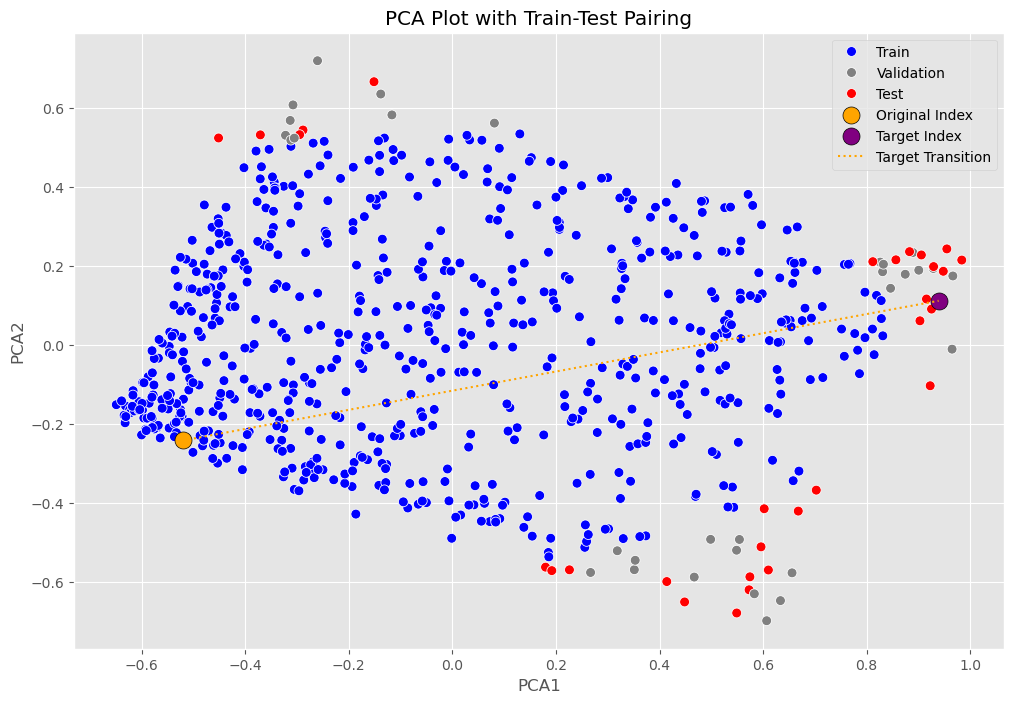

In [11]:
from src.data_transformations.generation_of_supervised_pairs import create_train_val_test_split_outliers

(
    X_train,
    y_train,
    X_validation,
    y_validation,
    X_test,
    y_test,
    train_supervised_dataset,
    validation_supervised_dataset,
    test_supervised_dataset,
) = create_train_val_test_split_outliers(
    pca_df=mts_pca_df,
    feature_df=feature_df,
    FEATURES_NAMES=FEATURES_NAMES,
    TARGET_NAMES=TARGET_NAMES,
    SEED=SEED,
    output_dir=''
)

## Correlation analysis
We then check the correlation values between the different features.

We then plot the correlation values.

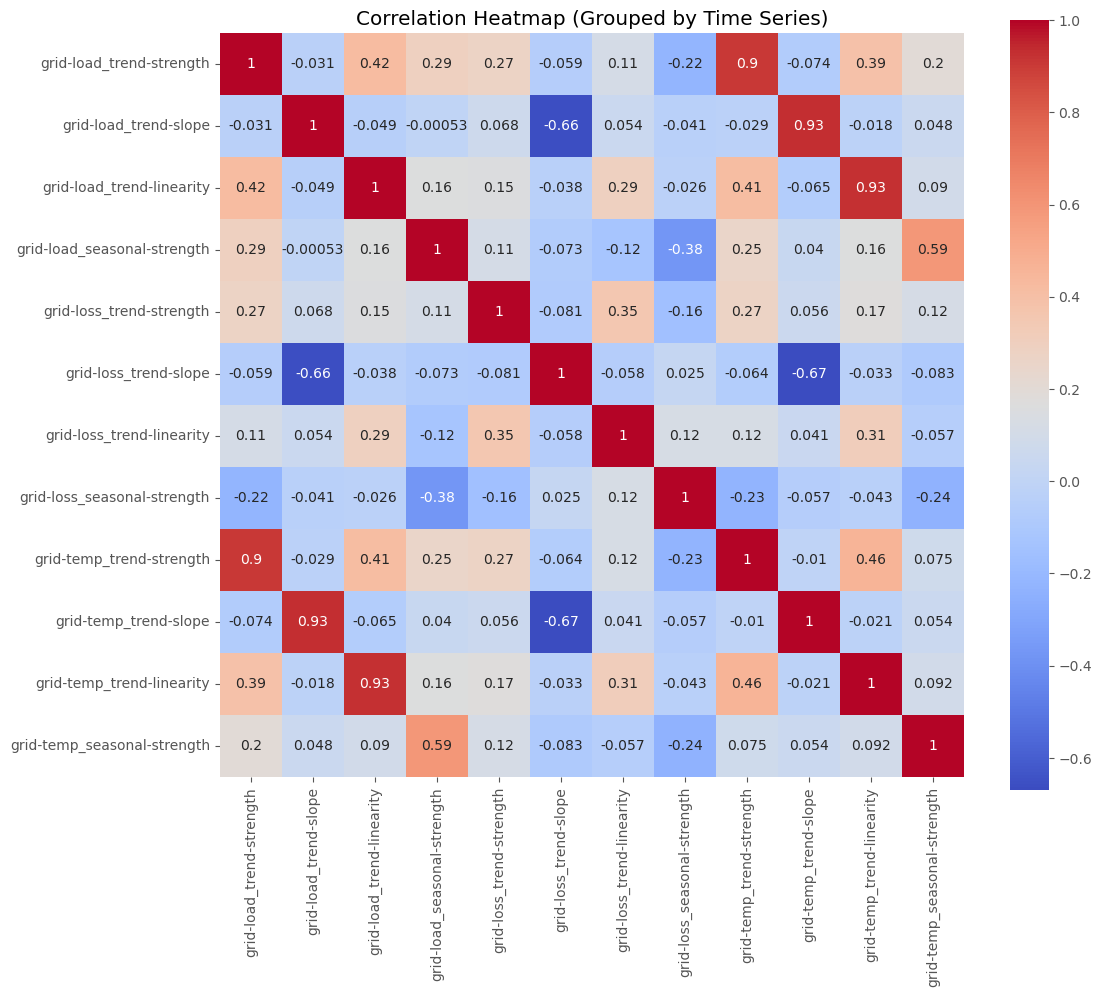

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt


corr_matrix = feature_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Grouped by Time Series)")
plt.show()


# Analysing training set

100%|██████████| 36/36 [00:42<00:00,  1.17s/it]


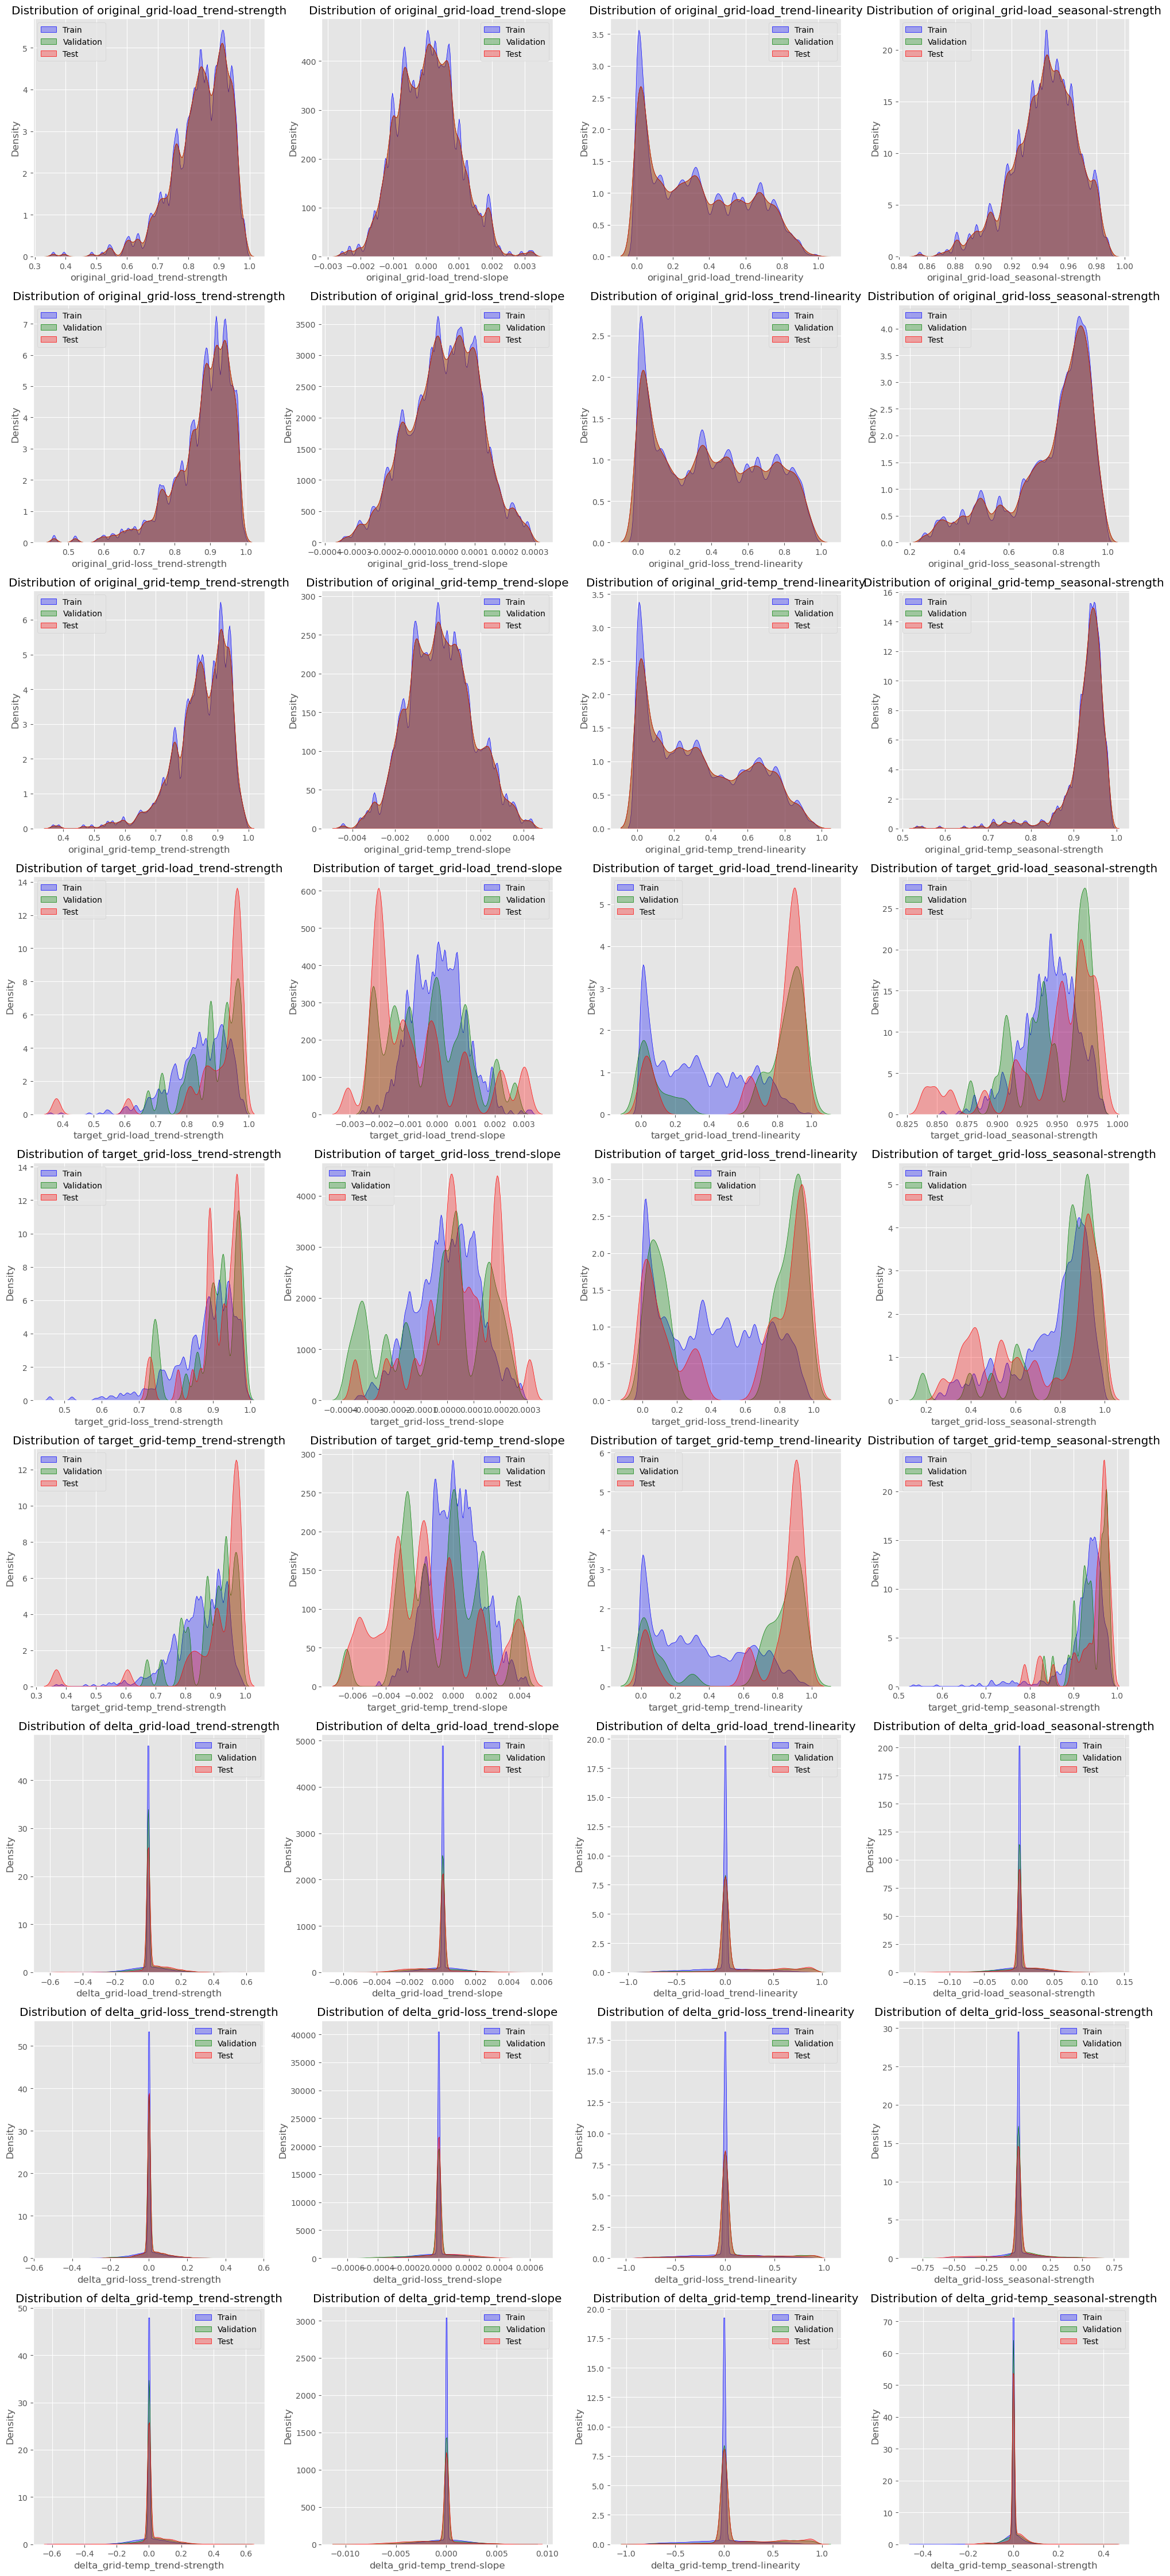

In [13]:
import math
from tqdm import tqdm

columns = [col for col in train_supervised_dataset.columns if col not in ['original_index', 'target_index', 'delta_index']]

# Define grid size
n_cols = 4  # Number of columns in the grid
n_rows = math.ceil(len(columns) / n_cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  
axes = axes.flatten()  # Flatten axes array to easily iterate

# Loop through each column and plot on the grid
for i, col in tqdm(enumerate(columns), total=len(columns)):
    ax = axes[i]
    
    # Plot KDE distributions
    sns.kdeplot(train_supervised_dataset[col], label='Train', color='blue', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(validation_supervised_dataset[col], label='Validation', color='green', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(test_supervised_dataset[col], label='Test', color='red', fill=True, alpha=0.3, ax=ax)
    
    # Titles and labels
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend()

# Remove empty subplots (if any)
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])  # Delete extra axes

# Adjust layout
plt.tight_layout()
plt.show()

# Training correlation model
We then build a correlation model. Using the previous correlation values, this model is intended to mathematically guess the new feature values based on the current ones and changes to one feature value. This is done like this:
1. Get the delta to the changed feature.
2. Get the correlation the changed feature has with all other features.
3. For each feature calulcate new feature value: $$New = value + delta * correlation factor $$

## Running inference through correlation model
First we use the training data to train the model

In [14]:
from src.models.naive_correlation import CorrelationModel


correlation_model = CorrelationModel()
correlation_model.train(feature_df)

Then we run inference through the logic developed in the correlation model

In [15]:
predictions_validation = correlation_model.infer(validation_supervised_dataset)
predictions_test = correlation_model.infer(test_supervised_dataset)

100%|██████████| 61566/61566 [00:35<00:00, 1722.45it/s]


In [16]:
predictions_validation.sample(1)

,grid-load_trend-strength,grid-load_trend-slope,grid-load_trend-linearity,grid-load_seasonal-strength,grid-loss_trend-strength,grid-loss_trend-slope,grid-loss_trend-linearity,grid-loss_seasonal-strength,grid-temp_trend-strength,grid-temp_trend-slope,grid-temp_trend-linearity,grid-temp_seasonal-strength,prediction_index
35275,0.871323,-0.012767,0.103385,0.844987,0.862266,0.007933,0.068904,0.885976,0.86931,-0.017663,0.086866,0.889382,35275.0


In [21]:
predictions_validation.sample(1)['prediction_index'].astype(int).values[0]

35946

In [18]:
validation_supervised_dataset.iloc[35275]

original_index                          408.000000
original_grid-load_trend-strength         0.942670
original_grid-load_trend-slope            0.000530
original_grid-load_trend-linearity        0.111725
original_grid-load_seasonal-strength      0.966588
original_grid-loss_trend-strength         0.914091
original_grid-loss_trend-slope           -0.000033
original_grid-loss_trend-linearity        0.028707
original_grid-loss_seasonal-strength      0.562185
original_grid-temp_trend-strength         0.943870
original_grid-temp_trend-slope            0.000888
original_grid-temp_trend-linearity        0.100674
original_grid-temp_seasonal-strength      0.966413
target_index                            682.000000
target_grid-load_trend-strength           0.954402
target_grid-load_trend-slope             -0.001574
target_grid-load_trend-linearity          0.949372
target_grid-load_seasonal-strength        0.975805
target_grid-loss_trend-strength           0.881603
target_grid-loss_trend-slope   

### Prediction plotting in PCA space
To be able to plot the predictions in PCA space we transform the dataframe into a numpy structure and run PCA on it.

In [16]:
from src.utils.data_formatting import use_model_predictions_to_create_dataframe


predictions_validation = use_model_predictions_to_create_dataframe(
    predictions_validation,
    TARGET_NAMES=TARGET_NAMES,
    target_dataframe=validation_supervised_dataset,
)

predictions_test = use_model_predictions_to_create_dataframe(
    predictions_test,
    TARGET_NAMES=TARGET_NAMES,
    target_dataframe=test_supervised_dataset,
)

/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_48728/2525083318.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


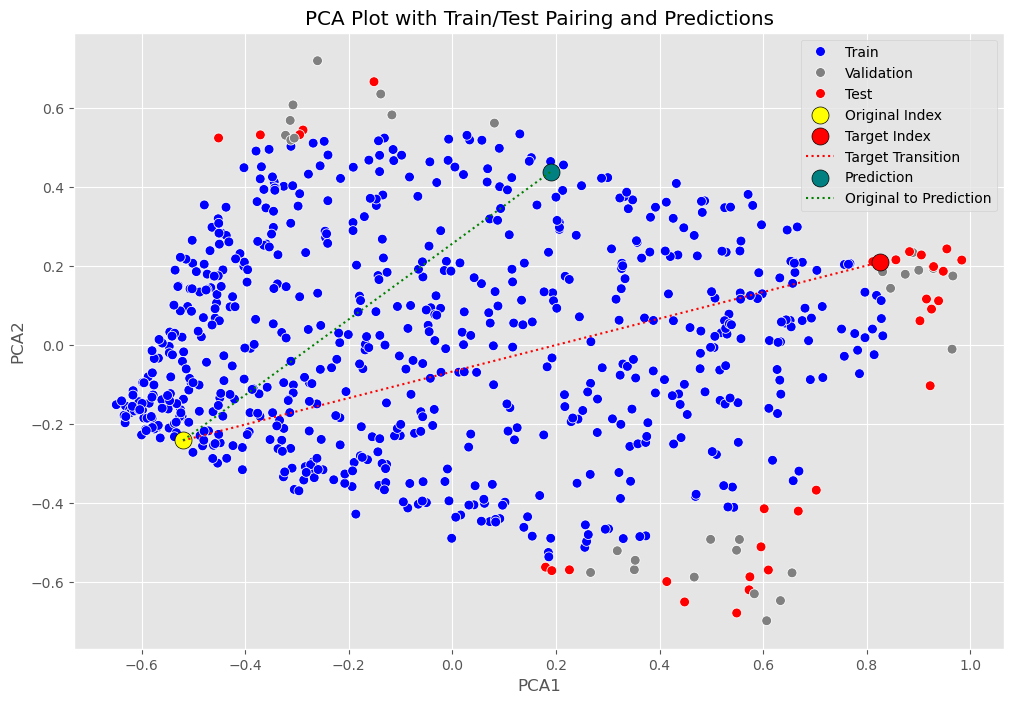

In [17]:

from src.plots.pca_train_test_pairing import pca_plot_train_test_pairing_with_one_prediction


predictions_without_index = predictions_validation.drop(columns=["prediction_index"])
predictions_pca = pca_transformer.transform(predictions_without_index)
predictions_validation["pca1"] = predictions_pca["pca1"]
predictions_validation["pca2"] = predictions_pca["pca2"]
prediction = predictions_validation.sample(n=1, random_state=SEED).reset_index(
    drop=True
)
index = prediction["prediction_index"][0]
dataset_row = validation_supervised_dataset.loc[index]
fig = pca_plot_train_test_pairing_with_one_prediction(
    mts_pca_df, dataset_row, prediction
)
fig.show()

# Analysis of results

## Model error analysis
We then look at which features the model does well on, and which it does not do well on. 

In [18]:
from src.utils.evaluation.feature_space_evaluation import find_error_of_each_feature_for_each_sample


differences_df_validation = find_error_of_each_feature_for_each_sample(
    predictions=predictions_validation,
    labelled_test_dataset=validation_supervised_dataset,
)
differences_df_test = find_error_of_each_feature_for_each_sample(
    predictions=predictions_test, labelled_test_dataset=test_supervised_dataset
)

100%|██████████| 61566/61566 [00:10<00:00, 6028.25it/s]


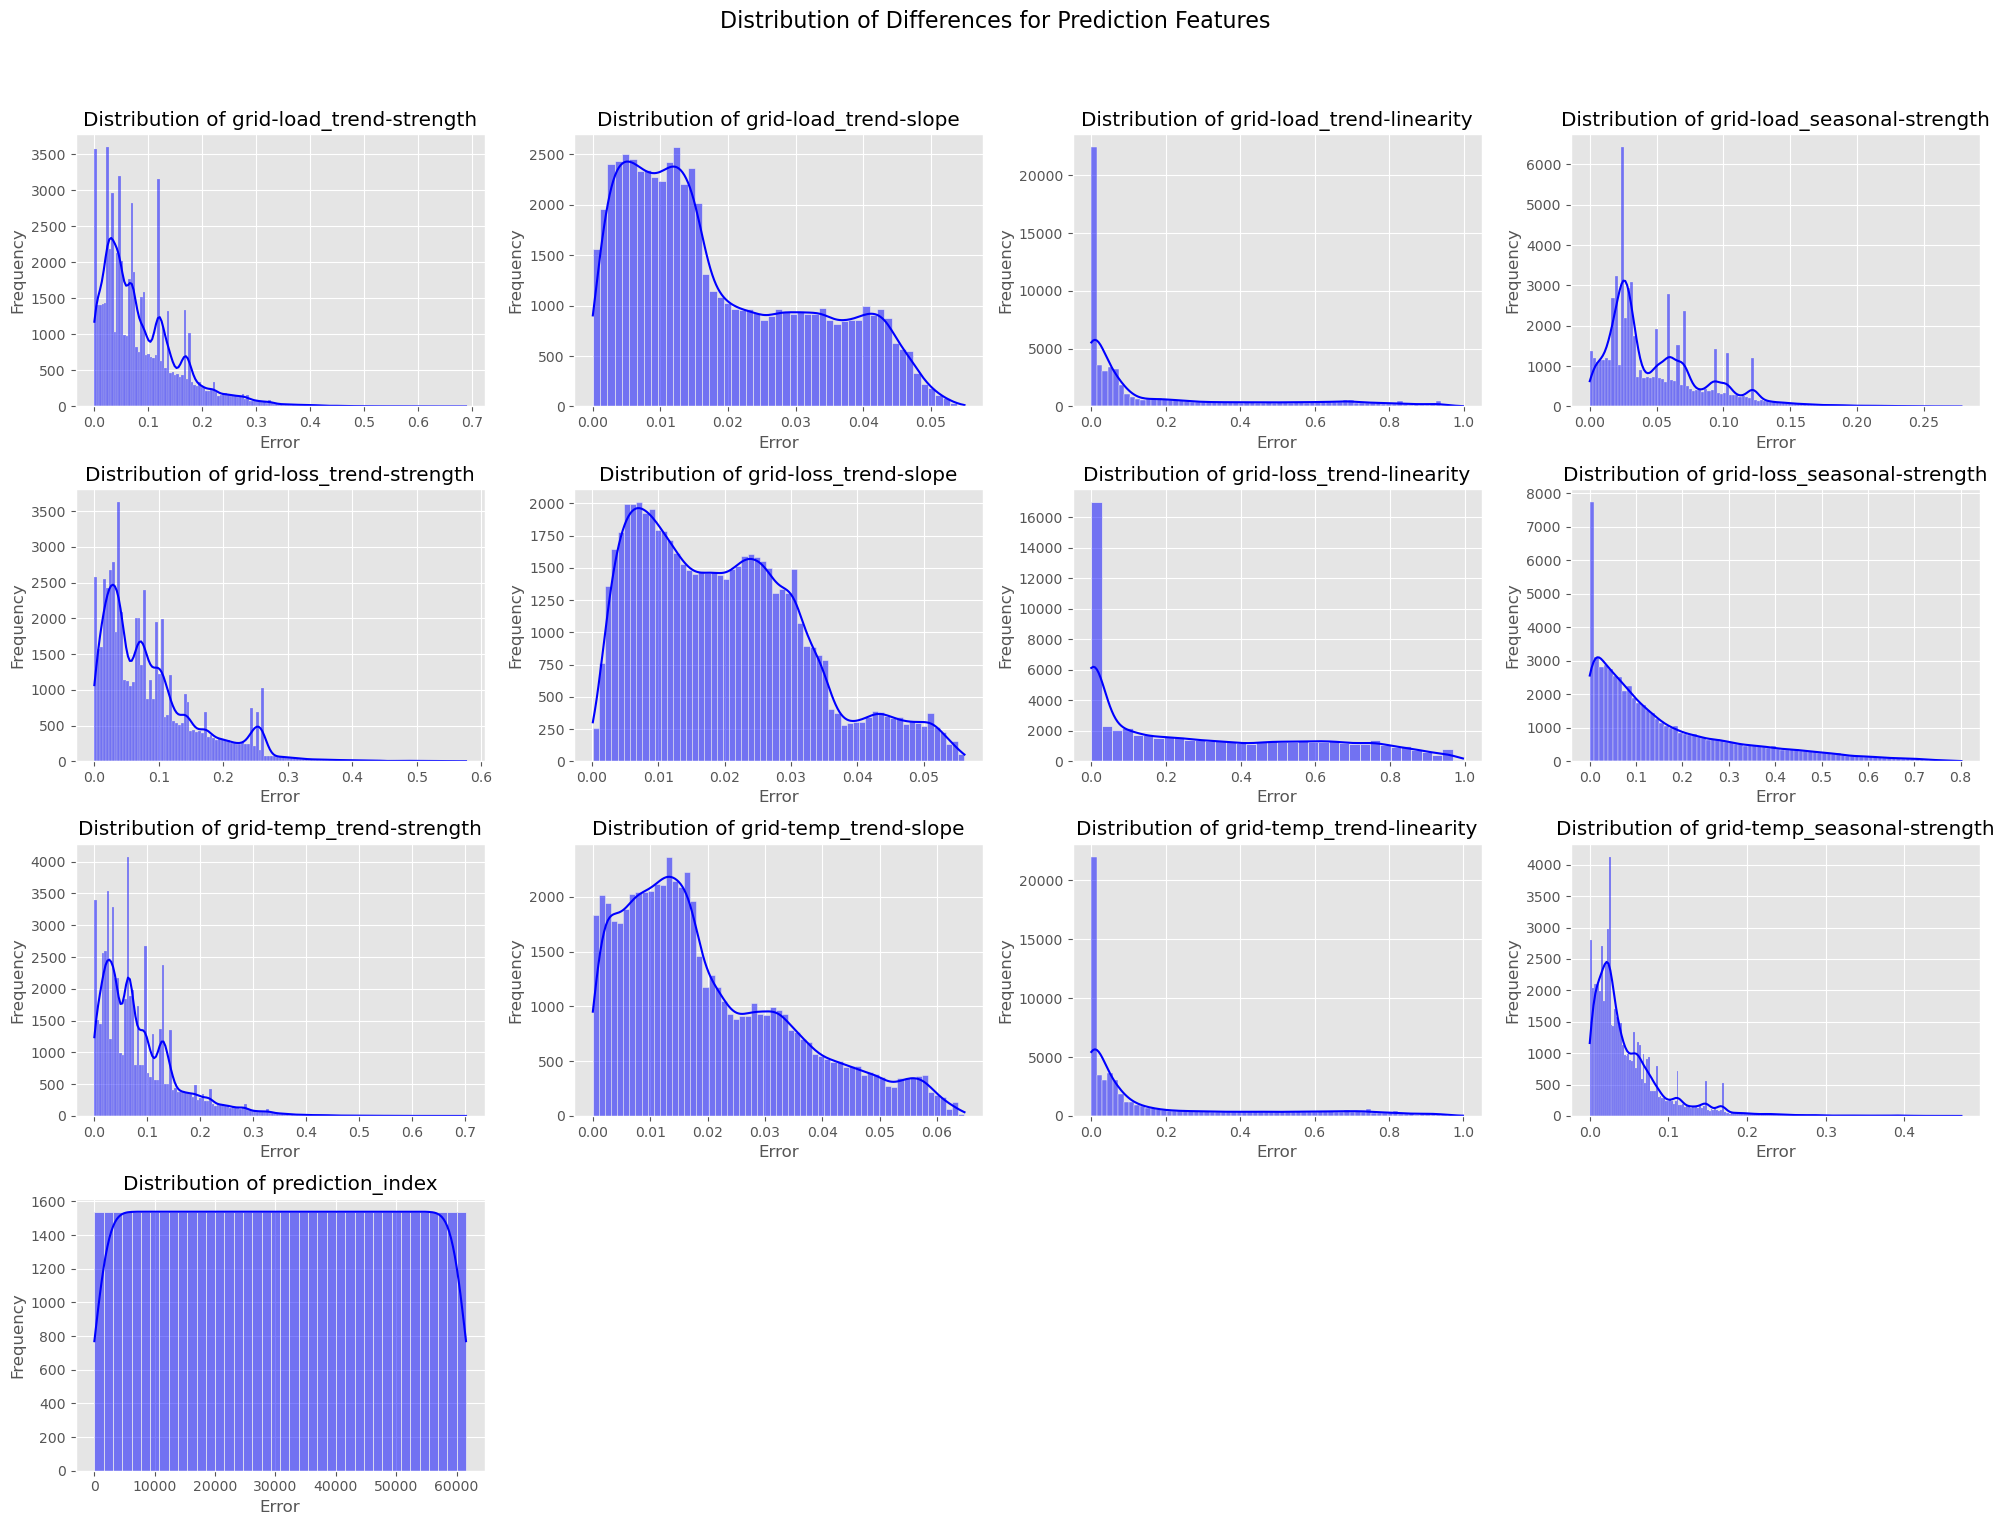

In [19]:
from src.plots.feature_wise_error import plot_distribution_of_feature_wise_error


fig = plot_distribution_of_feature_wise_error(differences_df_validation)

In [20]:
from src.utils.evaluation.mse import get_mse_for_features_and_overall


overall_mse_validation, mse_values_for_each_feature_validation = (
    get_mse_for_features_and_overall(differences_df_validation)
)
overall_mse_test, mse_values_for_each_feature_test = get_mse_for_features_and_overall(
    differences_df_test
)

print(
    f"Overall MSE for model\nValidation: {overall_mse_validation}\nTest: {overall_mse_test}"
)

2025-02-14 10:33:20,949 - INFO - Calculating MSE for each feature
2025-02-14 10:33:20,951 - INFO - Calculating overall MSE
2025-02-14 10:33:20,952 - INFO - Calculating MSE for each feature
2025-02-14 10:33:20,953 - INFO - Calculating overall MSE


Overall MSE for model
Validation: 0.0408791055978066
Test: 0.04059963238798613


As we can see, the model clearly has issues with trend linearity. These are also the most important features for the PCA plot. This is probably because the PCA plot uses the the features with the highest variance as its components. This causes the vizualization to break down on the predictions, while the model itself might be quite good.

### Why the model predicts the wrong direction

In [21]:
pca_correlation_df = feature_df.copy()
pca_correlation_df['pca1'] = mts_pca_df['pca1']
pca_correlation_df['pca2'] = mts_pca_df['pca2']

In [22]:
pca_corr = pca_correlation_df.corr()[['pca1', 'pca2']].T.drop(columns=['pca1', 'pca2'])
pca_corr.T

,pca1,pca2
grid-load_trend-strength,0.429486,-0.166857
grid-load_trend-slope,-0.015144,0.070511
grid-load_trend-linearity,0.944234,-0.259904
grid-load_seasonal-strength,0.123125,-0.259872
grid-loss_trend-strength,0.260903,0.255516
grid-loss_trend-slope,-0.050158,-0.034150
grid-loss_trend-linearity,0.543153,0.835680
grid-loss_seasonal-strength,-0.009820,0.245500
grid-temp_trend-strength,0.460875,-0.174502
grid-temp_trend-slope,-0.027545,0.061648


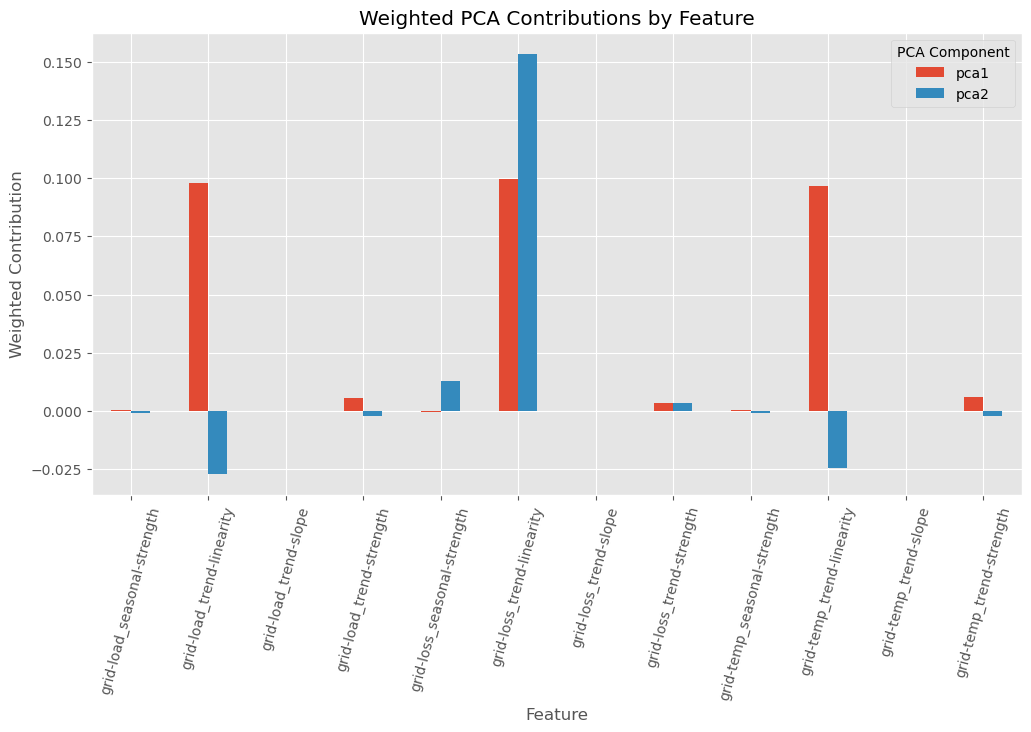

In [23]:

# Weighted PCA values
weighted_pca = pca_corr.multiply(mse_values_for_each_feature_validation, axis=1)

# Bar Plot
weighted_pca.T.plot(kind="bar", figsize=(12, 6))
plt.title("Weighted PCA Contributions by Feature")
plt.ylabel("Weighted Contribution")
plt.xlabel("Feature")
plt.legend(title="PCA Component")
plt.xticks(rotation=75)
plt.show()

## Tracing the worst prediction
We then trace the worst prediction made, to figure out why this prediction is made.

In [24]:
def get_error_for_each_row(differences_df):

    # Excluding 'prediction_index' without explicit dropping
    feature_columns = differences_df.columns.difference(["prediction_index"])

    differences_df['total_error'] = differences_df[feature_columns].sum(axis=1)

    return differences_df[['prediction_index', 'total_error']]

total_error_rowwise_validation = get_error_for_each_row(differences_df_validation)

In [25]:
worst_prediction_validation = total_error_rowwise_validation.loc[total_error_rowwise_validation['total_error'].idxmax()]['prediction_index']
worst_prediction_validation

45595.0

/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_48728/2622980994.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


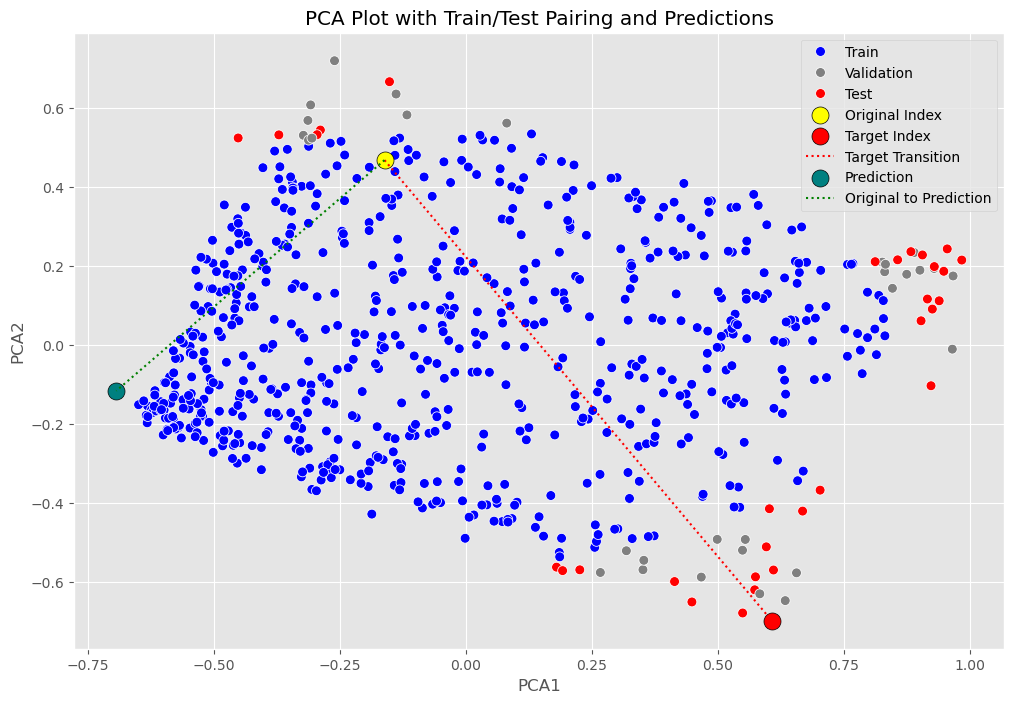

In [26]:
worst_prediction = predictions_validation[predictions_validation['prediction_index'] == worst_prediction_validation].reset_index(drop=True)
index = worst_prediction_validation
dataset_row = validation_supervised_dataset.loc[index]
fig = pca_plot_train_test_pairing_with_one_prediction(
    mts_pca_df, dataset_row, worst_prediction
)
fig.show()

In [27]:
worst_prediction_supervised_row = validation_supervised_dataset.iloc[[int(worst_prediction_validation)]].reset_index(drop=True)
worst_prediction_supervised_row

,original_index,original_grid-load_trend-strength,original_grid-load_trend-slope,original_grid-load_trend-linearity,original_grid-load_seasonal-strength,original_grid-loss_trend-strength,original_grid-loss_trend-slope,original_grid-loss_trend-linearity,original_grid-loss_seasonal-strength,original_grid-temp_trend-strength,...,delta_grid-load_trend-linearity,delta_grid-load_seasonal-strength,delta_grid-loss_trend-strength,delta_grid-loss_trend-slope,delta_grid-loss_trend-linearity,delta_grid-loss_seasonal-strength,delta_grid-temp_trend-strength,delta_grid-temp_trend-slope,delta_grid-temp_trend-linearity,delta_grid-temp_seasonal-strength
0,535.0,0.539691,-0.000163,0.22943,0.981386,0.954431,-0.000245,0.762267,0.860735,0.46477,...,0.0,0.0,-0.023231,0.000278,-0.719337,-0.466605,0.0,0.0,0.0,0.0


In [28]:
worst_prediction

,grid-load_trend-strength,grid-load_trend-slope,grid-load_trend-linearity,grid-load_seasonal-strength,grid-loss_trend-strength,grid-loss_trend-slope,grid-loss_trend-linearity,grid-loss_seasonal-strength,grid-temp_trend-strength,grid-temp_trend-slope,grid-temp_trend-linearity,grid-temp_seasonal-strength,prediction_index,pca1,pca2
0,0.458972,-0.039058,0.018934,1.0,0.699331,0.041468,0.04293,0.771432,0.377013,-0.029731,0.0,1.0,45595,-0.693336,-0.115334


/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_48728/2426551632.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


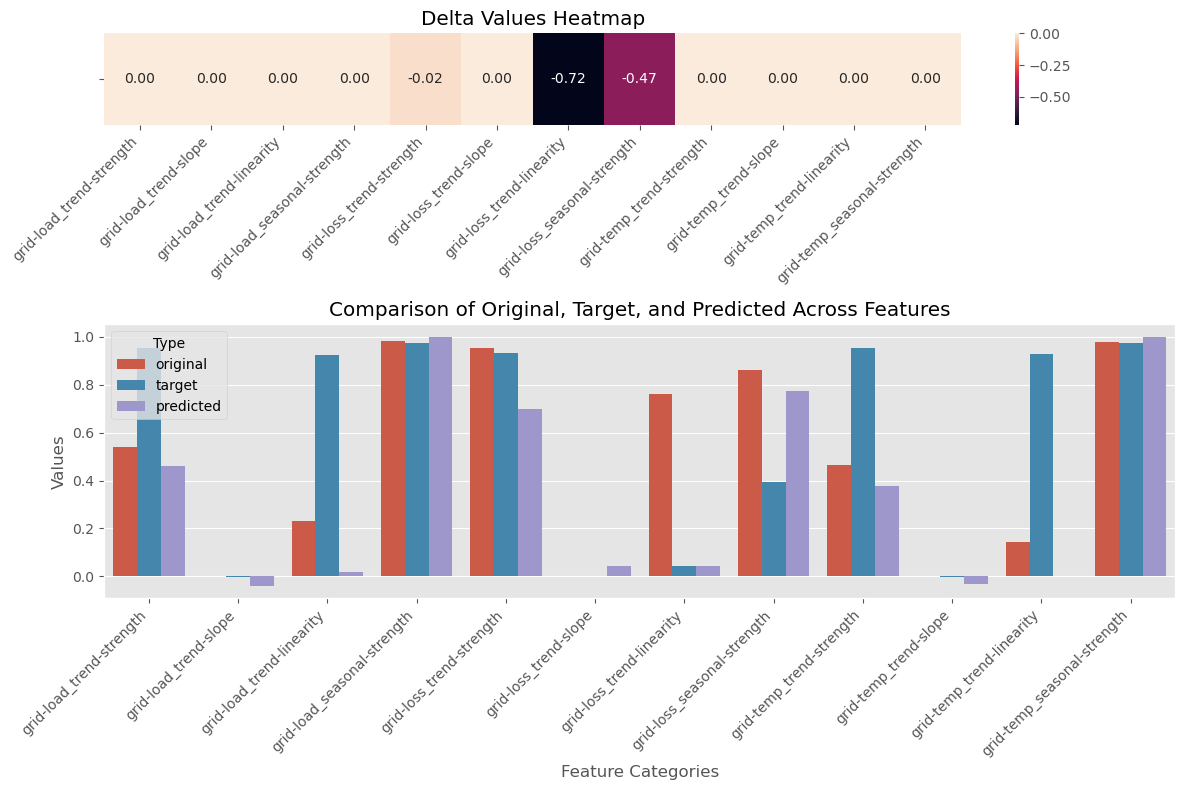

In [29]:
from collections import OrderedDict

# Remove 'pca1' and 'pca2' from worst_prediction, then rename columns with 'predicted_' prefix
worst_prediction_tmp = worst_prediction.drop(columns=['pca1', 'pca2'], errors='ignore').add_prefix("predicted_")

# Join the two DataFrames (assuming they have the same index)
worst_combined = pd.concat([worst_prediction_supervised_row, worst_prediction_tmp], axis=1)

# Drop index columns if they exist
worst_combined = worst_combined.drop(columns=[col for col in worst_combined.columns if 'index' in col], errors='ignore')

# Separate delta columns for heatmap
delta_cols = [col for col in worst_combined.columns if "delta_" in col]  # Preserve order
delta_df = worst_combined[delta_cols]

# Remove delta columns from the main DataFrame for bar plot
worst_combined = worst_combined.drop(columns=delta_cols)

# Maintain category order based on appearance in DataFrame
categories = OrderedDict.fromkeys([col.split('_', 1)[1] for col in worst_combined.columns])

melted_df = pd.DataFrame()

for cat in categories.keys():
    subset = worst_combined.filter(like=cat)  # Get columns related to this category
    temp_df = subset.melt(var_name="Type", value_name="Value")
    temp_df["Category"] = cat
    melted_df = pd.concat([melted_df, temp_df])

# Extract the labels (original, target, predicted) for coloring
melted_df["Type"] = melted_df["Type"].str.split('_').str[0]

# Reorder categories in melted_df to match heatmap order
melted_df["Category"] = pd.Categorical(melted_df["Category"], categories=list(categories.keys()), ordered=True)

# Sort by category order
melted_df = melted_df.sort_values("Category")

# Create Subplots
fig, axes = plt.subplots(nrows=2, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 3]})

# Heatmap for delta values
sns.heatmap(delta_df, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Delta Values Heatmap")
axes[0].set_xticklabels([col.replace("delta_", "") for col in delta_df.columns], rotation=45, ha="right")
axes[0].set_yticklabels([])  # Hide y-axis labels

# Bar plot for original, target, and predicted values
sns.barplot(x="Category", y="Value", hue="Type", data=melted_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_xlabel("Feature Categories")
axes[1].set_ylabel("Values")
axes[1].set_title("Comparison of Original, Target, and Predicted Across Features")

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
worst_prediction_supervised_row

,original_index,original_grid-load_trend-strength,original_grid-load_trend-slope,original_grid-load_trend-linearity,original_grid-load_seasonal-strength,original_grid-loss_trend-strength,original_grid-loss_trend-slope,original_grid-loss_trend-linearity,original_grid-loss_seasonal-strength,original_grid-temp_trend-strength,...,delta_grid-load_trend-linearity,delta_grid-load_seasonal-strength,delta_grid-loss_trend-strength,delta_grid-loss_trend-slope,delta_grid-loss_trend-linearity,delta_grid-loss_seasonal-strength,delta_grid-temp_trend-strength,delta_grid-temp_trend-slope,delta_grid-temp_trend-linearity,delta_grid-temp_seasonal-strength
0,535.0,0.539691,-0.000163,0.22943,0.981386,0.954431,-0.000245,0.762267,0.860735,0.46477,...,0.0,0.0,-0.023231,0.000278,-0.719337,-0.466605,0.0,0.0,0.0,0.0


In [31]:
melted_df

,Type,Value,Category
0,original,0.539691,grid-load_trend-strength
1,target,0.951809,grid-load_trend-strength
2,predicted,0.458972,grid-load_trend-strength
0,original,-0.000163,grid-load_trend-slope
1,target,-0.001510,grid-load_trend-slope
2,predicted,-0.039058,grid-load_trend-slope
0,original,0.229430,grid-load_trend-linearity
1,target,0.925383,grid-load_trend-linearity
2,predicted,0.018934,grid-load_trend-linearity
0,original,0.981386,grid-load_seasonal-strength
